In [1]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor

In [2]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [5]:
prices = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices_minute",{"ticker":ticker})).sort_values("date")
        price["average_return"] = price["adjclose"].pct_change(60)
        for i in range(10):
            price[str(i)] = price["adjclose"].shift(i)
        price["y"] = price["adjclose"].shift(-5)
        prices.append(price.dropna())
    except:
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:05<00:00, 98.47it/s]


In [6]:
prices = pd.concat(prices).sort_values("date")

In [27]:
training_data = prices[prices["date"]<=list(prices["date"].unique())[100]]
sim = prices[prices["date"]>=list(prices["date"].unique())[100]]

In [28]:
model = XGBRegressor(fit_intercept=True)
model.fit(training_data[[str(i) for i in range(7)]],training_data["y"])
sim["predictions"] = model.predict(sim[[str(i) for i in range(7)]])

E:\projects\sapling\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:30:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "fit_intercept" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\eric\AppData\Local\Temp\ipykernel_14124\163595079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim["predictions"] = model.predict(sim[[str(i) for i in range(7)]])


In [29]:
sim = sim.sort_values("date")
dates = sim["date"].unique()
sim["expected_return"] = (sim["predictions"] - sim["adjclose"]) / sim["adjclose"]

In [33]:
default_portfolio = {"ticker":"","adjclose":0,"quantity":0,"buy_price":0}
cash = 100
portfolio = default_portfolio.copy()
portfolios = []
for date in tqdm(dates):
    try:
        today = sim[sim["date"]==date]
        rec = today.sort_values("average_return",ascending=True).iloc[0]
        if portfolio["ticker"] == "":
            portfolio["ticker"] = rec["ticker"]
            portfolio["adjclose"] = rec["adjclose"]
            portfolio["quantity"] = cash / rec["adjclose"]
            portfolio["buy_price"] = rec["adjclose"]
            portfolio["date"] = date
            cash = 0
            portfolios.append(portfolio.copy())
        else:
            ## update
            updates = today[today["ticker"]==portfolio["ticker"]].iloc[0]
            portfolio["adjclose"] = updates["adjclose"]
            portfolio["date"] = date
            if rec["ticker"] != portfolio["ticker"] and updates["expected_return"] < 0:
                cash = portfolio["adjclose"] * portfolio["quantity"]
                portfolio["ticker"] = rec["ticker"]
                portfolio["adjclose"] = rec["adjclose"]
                portfolio["quantity"] = cash / rec["adjclose"]
                portfolio["buy_price"] = rec["adjclose"]
                portfolio["date"] = date
                cash = 0
                portfolios.append(portfolio.copy())
            else:
                portfolios.append(portfolio.copy())
    except Exception as e:
        print(str(e))
        continue

  9%|████████████▏                                                                                                                      | 74/795 [00:00<00:00, 735.40it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 39%|███████████████████████████████████████████████████                                                                               | 312/795 [00:00<00:00, 757.85it/s]

single positional indexer is out-of-bounds


 58%|███████████████████████████████████████████████████████████████████████████▌                                                      | 462/795 [00:00<00:00, 733.58it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 697/795 [00:00<00:00, 771.90it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 795/795 [00:01<00:00, 759.43it/s]


In [34]:
states = pd.DataFrame(portfolios)
states["pv"] = states["adjclose"] * states["quantity"]

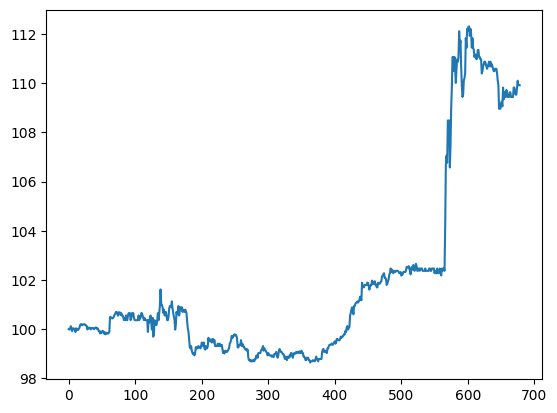

In [35]:
plt.plot(states["pv"])